In [1]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [2]:
# Veri Seti
# Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
# Period of Record: March 1958 - December 2001

data = sm.datasets.co2.load_pandas()
y = data.data
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill())
train = y[:'1997-12-01']
test = y['1998-01-01':]

In [3]:
train.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [4]:
test.head()

1998-01-01    365.340
1998-02-01    366.200
1998-03-01    367.375
1998-04-01    368.525
1998-05-01    369.140
Freq: MS, Name: co2, dtype: float64

### ARIMA(p,d,q): Autoregressive Integrated Moving Average

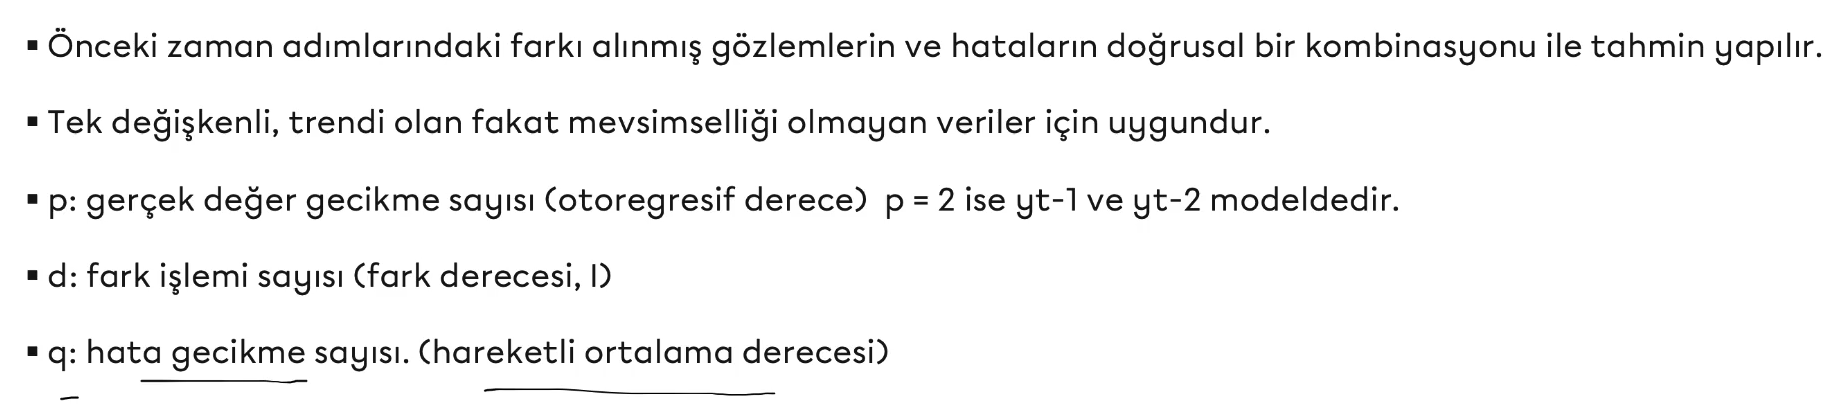

In [5]:
model = sm.tsa.arima.ARIMA(train, order=(1, 1, 1)) # order(1,1,1) -> (p,d,q)
arima_model = model.fit()

arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  478
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -575.768
Date:                Tue, 02 Apr 2024   AIC                           1157.537
Time:                        23:00:38   BIC                           1170.039
Sample:                    03-01-1958   HQIC                          1162.452
                         - 12-01-1997                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5669      0.054     10.586      0.000       0.462       0.672
ma.L1          0.3284      0.062      5.306      0.000       0.207       0.450
sigma2         0.6534      0.050     12.965      0.000       0.555       0.752
===================================================================================
Ljung-Box (L1) (Q):                   2.26   Jarque-Bera (JB):                 3.96
Prob(Q):                              0.13   Prob(JB):                         0.14
Heteroskedasticity (H):               0.98   Skew:                             0.09
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
y_pred = arima_model.get_forecast(steps=48).predicted_mean
y_pred = pd.Series(y_pred, index=test.index)
y_pred

1998-01-01    365.558639
1998-02-01    366.300479
1998-03-01    366.721012
1998-04-01    366.959404
1998-05-01    367.094543
1998-06-01    367.171151
1998-07-01    367.214578
1998-08-01    367.239196
1998-09-01    367.253151
1998-10-01    367.261062
1998-11-01    367.265547
1998-12-01    367.268089
1999-01-01    367.269530
1999-02-01    367.270347
1999-03-01    367.270810
1999-04-01    367.271073
1999-05-01    367.271222
1999-06-01    367.271306
1999-07-01    367.271354
1999-08-01    367.271381
1999-09-01    367.271396
1999-10-01    367.271405
1999-11-01    367.271410
1999-12-01    367.271413
2000-01-01    367.271414
2000-02-01    367.271415
2000-03-01    367.271416
2000-04-01    367.271416
2000-05-01    367.271416
2000-06-01    367.271416
2000-07-01    367.271416
2000-08-01    367.271417
2000-09-01    367.271417
2000-10-01    367.271417
2000-11-01    367.271417
2000-12-01    367.271417
2001-01-01    367.271417
2001-02-01    367.271417
2001-03-01    367.271417
2001-04-01    367.271417


In [7]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

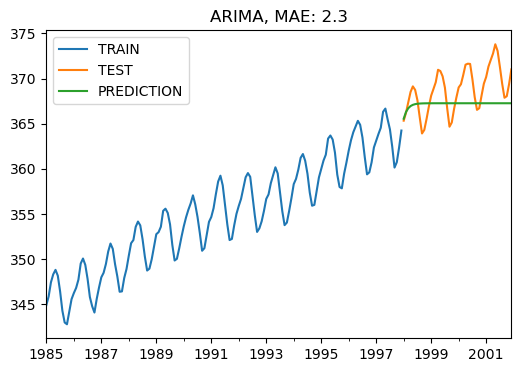

In [8]:
plot_co2(train, test, y_pred, "ARIMA")

In [9]:
# Hyperparameter Optimization (Model Derecelerini Belirleme)
#-----------------------------------------------------------------

# AIC & BIC İstatistiklerine Göre Model Derecesini Belirleme

def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model = sm.tsa.ARIMA(train, order=order).fit()
            aic = arima_model.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

In [10]:
p = d = q = range(0, 4)

pdq = list(itertools.product(p, d, q))

best_params_aic = arima_optimizer_aic(train, pdq)

ARIMA(0, 0, 0) AIC=3954.01
ARIMA(0, 0, 1) AIC=3312.73
ARIMA(0, 0, 2) AIC=2771.31
ARIMA(0, 0, 3) AIC=2327.85
ARIMA(0, 1, 0) AIC=1523.91
ARIMA(0, 1, 1) AIC=1254.79
ARIMA(0, 1, 2) AIC=1137.97
ARIMA(0, 1, 3) AIC=1094.51
ARIMA(0, 2, 0) AIC=1279.81
ARIMA(0, 2, 1) AIC=1257.89
ARIMA(0, 2, 2) AIC=1247.74
ARIMA(0, 2, 3) AIC=1141.50
ARIMA(0, 3, 0) AIC=1482.91
ARIMA(0, 3, 1) AIC=1286.29
ARIMA(0, 3, 2) AIC=1264.05
ARIMA(0, 3, 3) AIC=1253.48
ARIMA(1, 0, 0) AIC=1536.61
ARIMA(1, 0, 1) AIC=1267.22
ARIMA(1, 0, 2) AIC=1149.98
ARIMA(1, 0, 3) AIC=1105.72
ARIMA(1, 1, 0) AIC=1207.78
ARIMA(1, 1, 1) AIC=1157.54
ARIMA(1, 1, 2) AIC=1113.98
ARIMA(1, 1, 3) AIC=1095.90
ARIMA(1, 2, 0) AIC=1256.05
ARIMA(1, 2, 1) AIC=1257.80
ARIMA(1, 2, 2) AIC=1161.11
ARIMA(1, 2, 3) AIC=1117.55
ARIMA(1, 3, 0) AIC=1418.84
ARIMA(1, 3, 1) AIC=1262.07
ARIMA(1, 3, 2) AIC=1263.84
ARIMA(1, 3, 3) AIC=1253.50
ARIMA(2, 0, 0) AIC=1217.86
ARIMA(2, 0, 1) AIC=1168.38
ARIMA(2, 0, 2) AIC=1124.96
ARIMA(2, 0, 3) AIC=1106.92
ARIMA(2, 1, 0) AIC=1103.53
A

In [11]:
# Final Model

# Fit the final ARIMA model using the best hyperparameters selected by AIC
arima_model = sm.tsa.ARIMA(train, order=best_params_aic).fit()

In [12]:
# Make predictions for the test set
y_pred = arima_model.forecast(steps=len(test))

In [13]:
# Convert predictions to a pandas Series with the correct index
y_pred = pd.Series(y_pred, index=test.index)

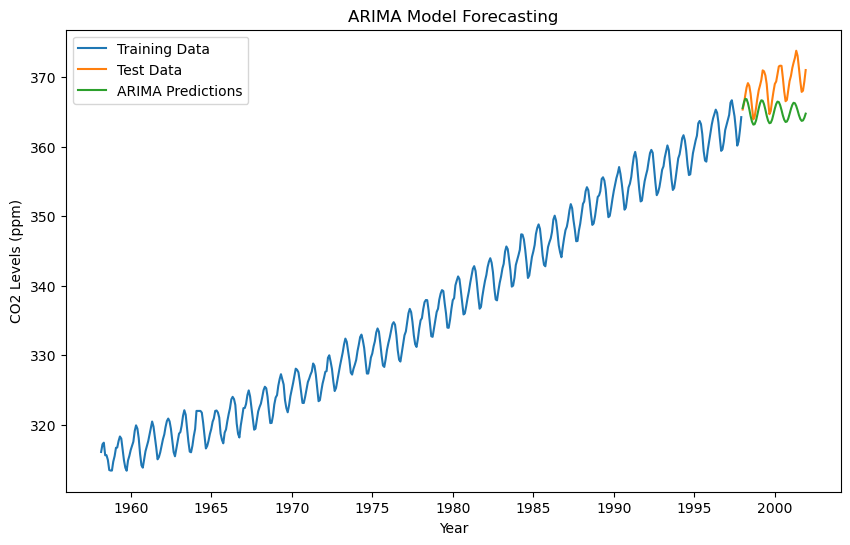

In [14]:
# Plot the actual data and the predictions
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(y_pred, label='ARIMA Predictions')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CO2 Levels (ppm)')
plt.title('ARIMA Model Forecasting')
plt.show()

### SARIMA (p,d,q)(P,D,Q)m: Seasonal Autoregressive Integrated Moving Average

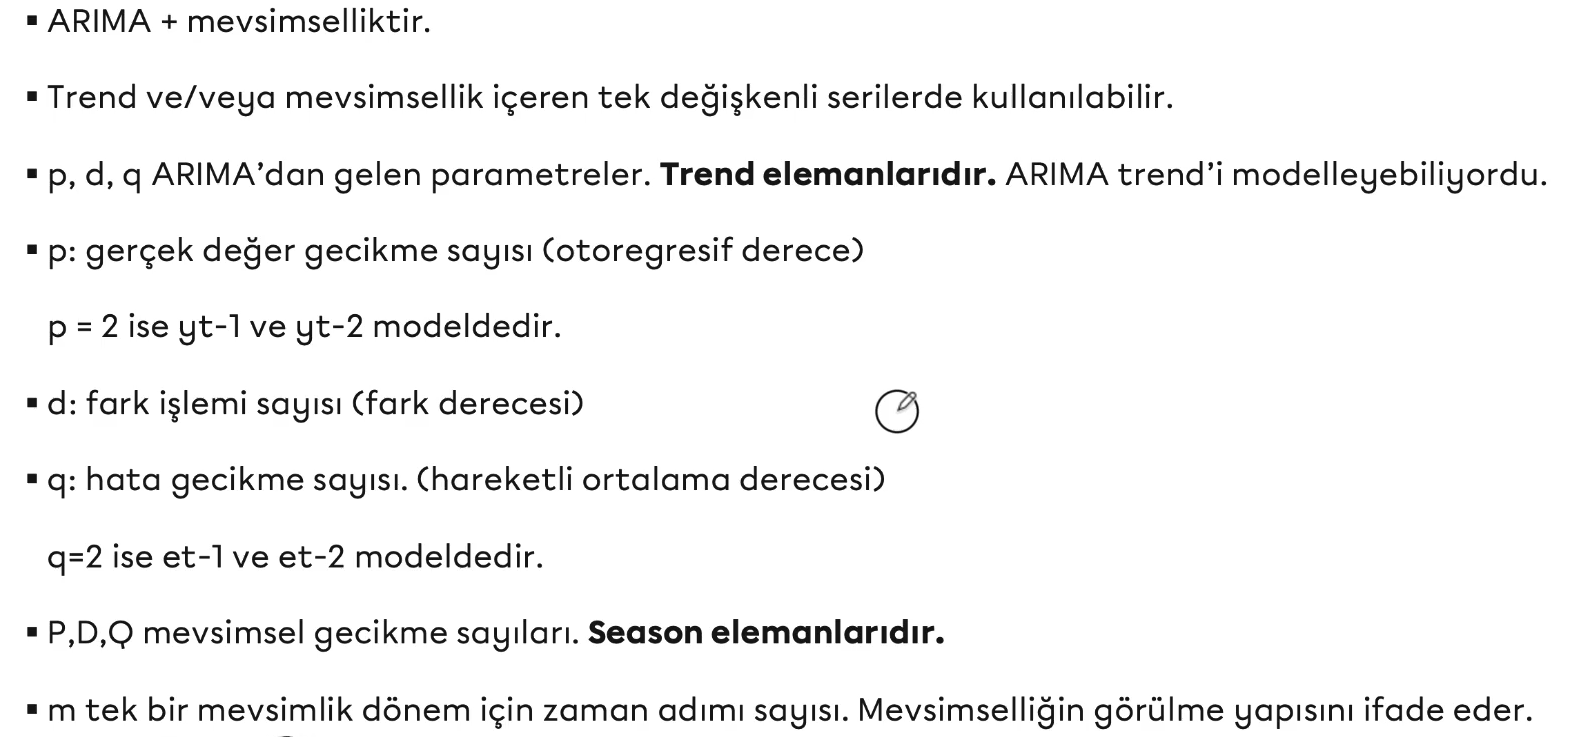



In [15]:
model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))
sarima_model = model.fit(disp=0)
# (1, 0, 1) -> (p,d,q)
# (0, 0, 0, 12) -> (P,D,Q,m)

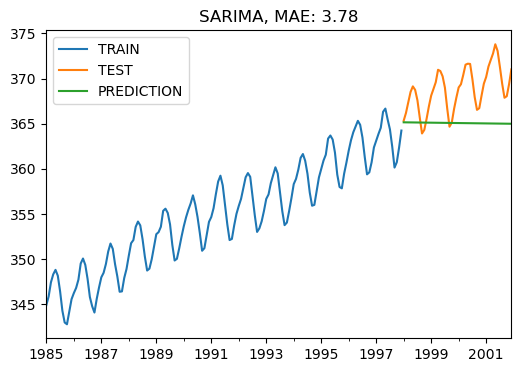

In [16]:
y_pred_test = sarima_model.get_forecast(steps=48)

y_pred = y_pred_test.predicted_mean

y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

In [17]:
# Hyperparameter Optimization

def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

In [18]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6922.606550808509
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6318.305219681159
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1643.9996657880365
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1428.2938925355725
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1887.8878801604324
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1645.4326283771993
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1205.0254009699665
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:973.207728191976
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6269.190364740715
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5663.567926702879
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1229.8447515742268
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1126.5843176950543
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1543.6820893123327
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1008.1602684875838
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:767.6332845170372
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1523.9134546906607
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1154.7436199042236
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:

In [20]:
best_order

(1, 1, 1)

In [21]:
best_seasonal_order

(0, 1, 1, 12)

In [22]:
# Final Model

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

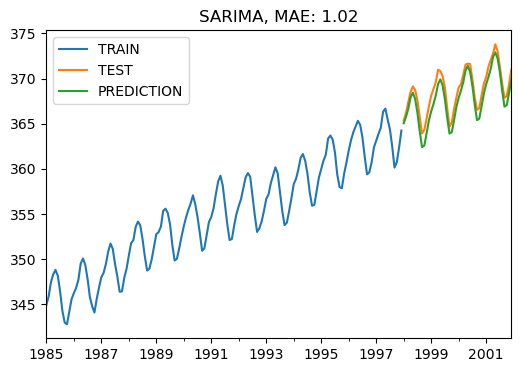

In [23]:
y_pred_test = sarima_final_model.get_forecast(steps=48)

y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

In [24]:
# Optimization by MAE

def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=48)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

In [25]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:368.7634375
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:324.17909156740444
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:5.063020833333329
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:4.803324370011304
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:5.139145138569996
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:4.874312784212858
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:3.3237252189636535
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:1.5279661031408054
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:364.9178691427669
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:320.4050598294032
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:4.985339488748218
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:4.765306202004695
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:5.065066730526546
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:3.674148723917156
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:1.5667159653067675
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:4.526979166666664
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:3.931540144560022
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - MAE:0.6419791666

In [26]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

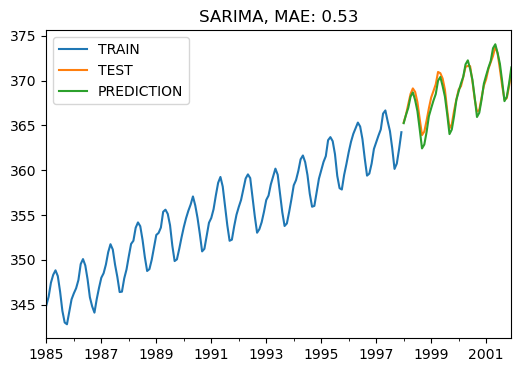

In [27]:
y_pred_test = sarima_final_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

In [28]:
# Final Model with all data by MAE

model = SARIMAX(y, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

future_predict = sarima_final_model.get_forecast(steps=6)
future_predict = future_predict.predicted_mean
future_predict

2002-01-01    371.930524
2002-02-01    372.718078
2002-03-01    373.585291
2002-04-01    374.494052
2002-05-01    375.101897
2002-06-01    374.687870
Freq: MS, Name: predicted_mean, dtype: float64